# Visualization of Nanostring DSP subtissues

The original data of **Nanostring DSP** technology is different from other technologies, It consists of a number of points to form a ROI, and then the ROI shows the merge expression level. Here we use this tutorial to better visualize the DSP data.

The more complete week 13 slides were used for presentation. Image data can be downloaded from https://nanostring.com/products/geomx-digital-spatial-profiler/spatial-organ-atlas/mouse-development/.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt

/home/wangheqi/anaconda3/envs/SpatialOmics/lib/python3.9/site-packages/soapy/pp/utils.py:9: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _filter_of_graph(obs: pd.DataFrame,
/home/wangheqi/anaconda3/envs/SpatialOmics/lib/python3.9/site-packages/soapy/tl/utils.py:66: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @nb.jit()


### Read

Read the Anndata data generated in `Read spatial omics` tutorial.

In [2]:
adata = sc.read_h5ad('mouse_embryo_dsp_adata.h5ad')
image = tiff.imread('/csb2/project/tmp_download/GeoMx_MouseDevelopment/image_files/mu_dev_E13_image_files/mu_dev_E13_006.ome.tiff')
image = image[0, :, :]

In [3]:
adata.obs.columns

Index(['SlideName', 'ScanLabel', 'ROILabel', 'SegmentLabel', 'QCFlags',
       'AOISurfaceArea', 'AOINucleiCount', 'ROICoordinateX', 'ROICoordinateY',
       'RawReads', 'AlignedReads', 'DeduplicatedReads', 'TrimmedReads',
       'StitchedReads', 'SequencingSaturation', 'SequencingSetID', 'UMIQ30',
       'RTSQ30', 'GeoMxNgsPipelineVersion',
       'LOT_Mouse_NGS_Whole_Transcriptome_Atlas_RNA', 'Tissue_annotation',
       'Tissue', 'p63_expression', 'Tissue_substructure', 'Tissue_type',
       'Timepoint', 'ROIID', 'SegmentID', 'ScanWidth', 'ScanHeight',
       'ScanOffsetX', 'ScanOffsetY',
       'LOQ (Mouse NGS Whole Transcriptome Atlas RNA)', 'NormalizationFactor',
       'ExpressionFilteringThreshold (Mouse NGS Whole Transcriptome Atlas RNA)'],
      dtype='object')

In [4]:
adata.uns['point']

,slide,roi,x,y
0,mu_dev_E13_006,1,13011.793535,10484.417086
1,mu_dev_E13_006,1,13109.708338,10499.139178
2,mu_dev_E13_006,1,13184.708338,10547.123928
3,mu_dev_E13_006,1,13242.708338,10642.093747
4,mu_dev_E13_006,1,13261.840745,10730.656697
...,...,...,...,...
4171,mu_dev_E13_011,58,4548.893838,10387.159712
4172,mu_dev_E13_011,58,4477.882657,10362.799483
4173,mu_dev_E13_011,58,4437.660936,10371.299021
4174,mu_dev_E13_011,58,4487.202775,10425.060315


### Preprocessing

We used subtissues of the heart, lung, and midgut for visualization.

In [5]:
adata = adata[np.isin(adata.obs['Tissue'], ['Heart', 'Lung', 'Midgut']), :].copy()
adata.obs['Tissue_s'] = adata.obs['Tissue'].astype(str) + ' ' + adata.obs['Tissue_substructure'].astype(str)

In [6]:
Slide_name = 'mu_dev_E13_006'

tissue_list = ['Heart Trabecula', 'Heart Valve', 'Heart Wall', 'Lung Epithelium',
                'Lung Mesenchyme', 'Midgut Epithelium', 'Midgut Mesenchyme', 'Midgut Neuron']

color_dict = {
    'Heart Trabecula': '#beeac4',
    'Heart Valve': '#800000',
    'Heart Wall': '#fa6d1d',
    'Lung Epithelium': '#4169e1',
    'Lung Mesenchyme': '#ee82ee',
    'Midgut Epithelium': '#da1f18',
    'Midgut Mesenchyme': '#ffe5b4',
    'Midgut Neuron': '#f47a75'
}

In [7]:
# Gray scale transformation
image = image / 23758 * 255*2

In [8]:
obs_inf = adata.obs.copy()
obs_inf = obs_inf[obs_inf['SlideName'] == Slide_name]

point_inf = adata.uns['point'].copy()
point_inf = point_inf[point_inf['slide'] == Slide_name]

points_roi = {}
for index in point_inf['roi'].unique():
    roi = point_inf[point_inf['roi'] == index]
    points_roi[index] = list(zip(roi['x'], roi['y']))

### Visualization

Place the original image and the spot distribution of the sub-tissues on two layers and then show them separately.

/tmp/ipykernel_13525/2934043088.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


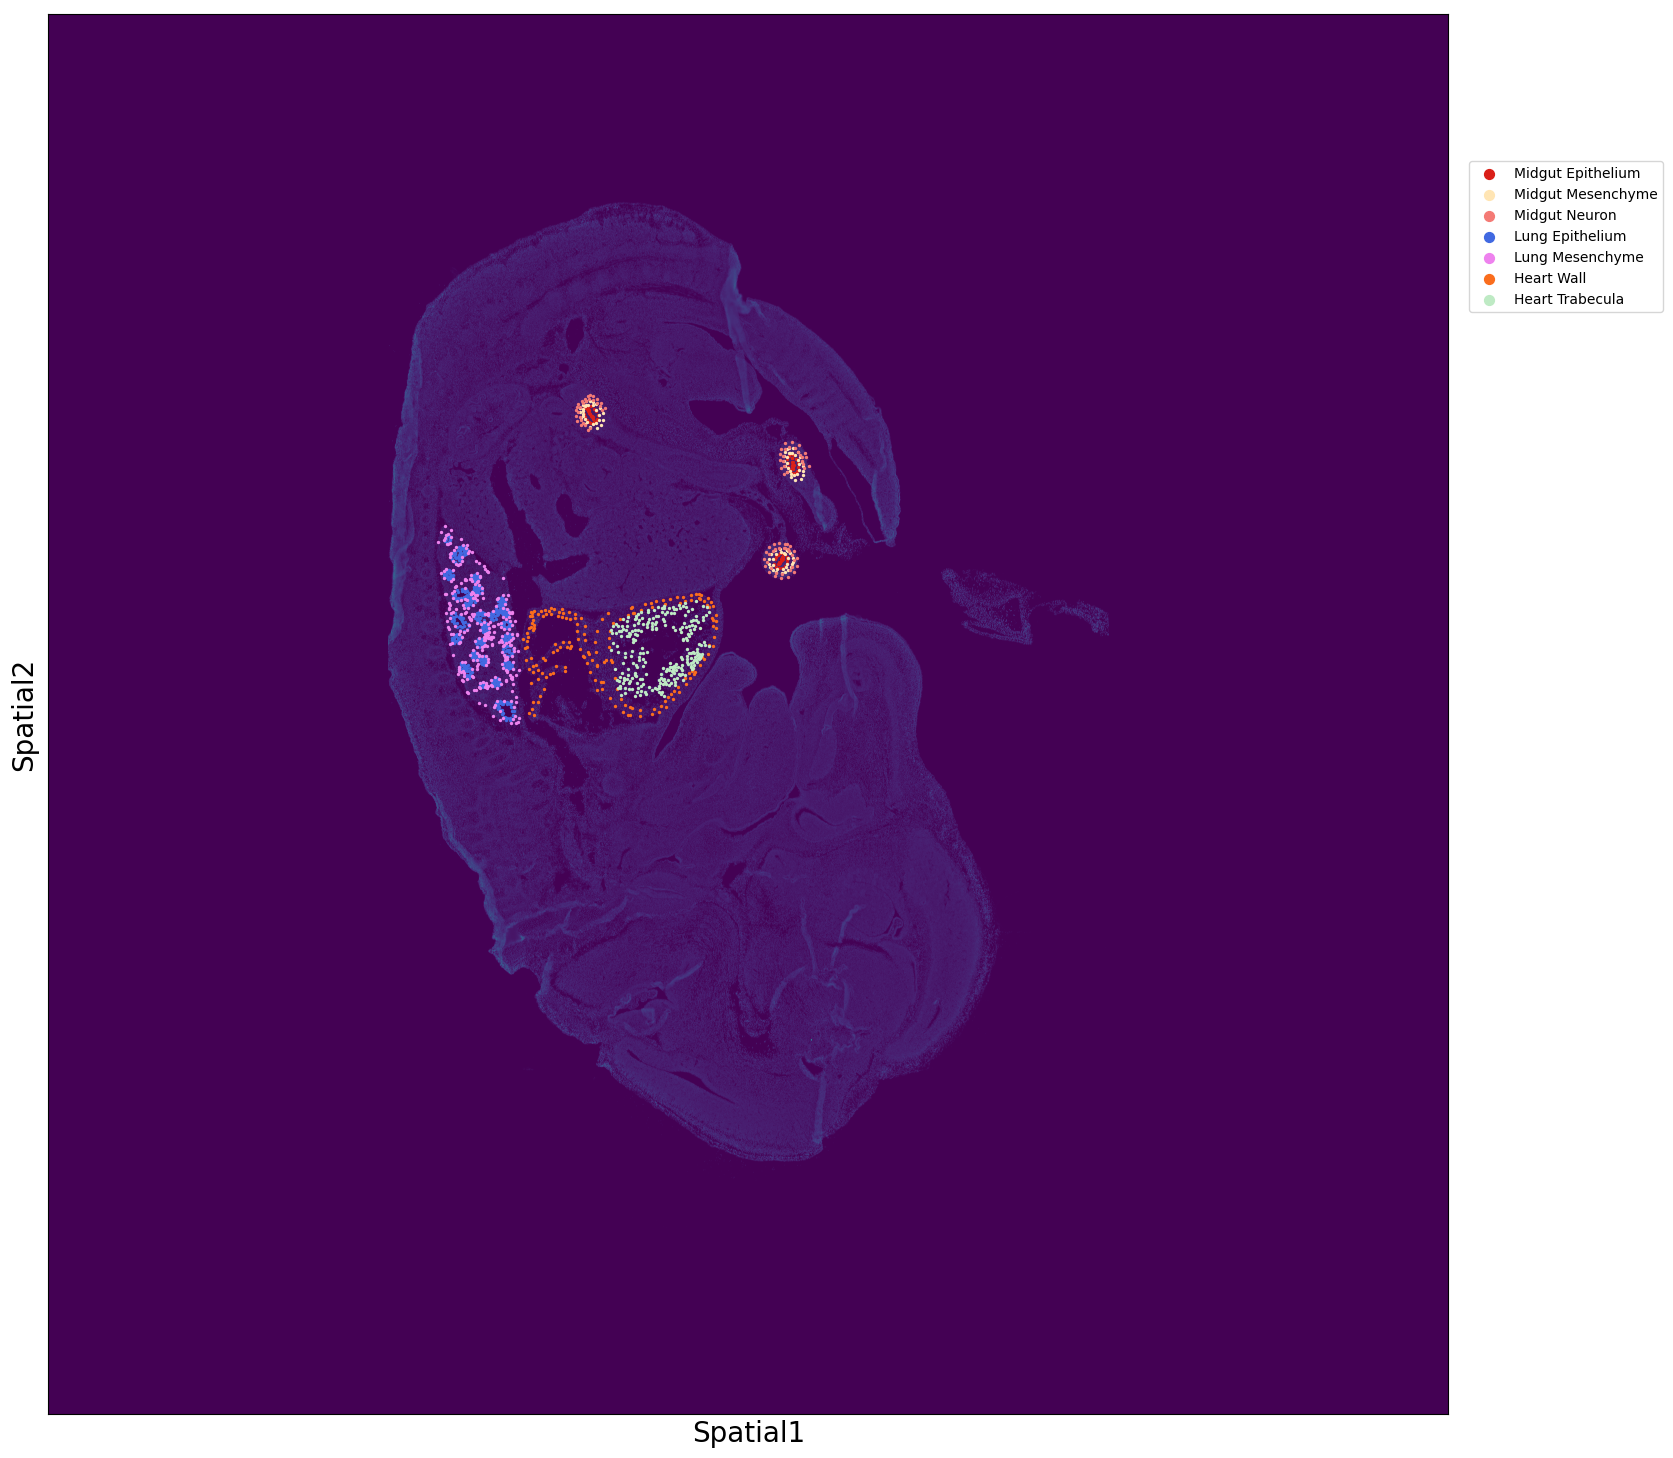

In [9]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_axes([0.1, 0.15, 0.7, 0.7])
ax.xaxis.set_ticks_position('top')
ax.invert_yaxis()

# plot subtissues
for row in obs_inf.itertuples():
    subt = getattr(row, 'Tissue_s')
    if subt in tissue_list:
        # print(getattr(row, 'ROILabel'), getattr(row, 'Tissue_substructure'))
        for point in points_roi[getattr(row, 'ROILabel')]:
            x, y = point
            ax.scatter(x, y, c=color_dict[subt], label=subt, s=2, zorder=2)
            
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Spatial1', size=20)
ax.set_ylabel('Spatial2', size=20)

handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    
ax.legend(*zip(*unique), bbox_to_anchor=(1.01, 0.9), loc='upper left', markerscale=5)

# plot image
ax.imshow(image, zorder=1)

fig.show()